
# Dataset and Dataloader
Code for processing data samples can become messy and hard to maintain; ideally, we want our dataset code to be separated from the model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your custom data.

<font color="green">Dataset:</font>

Dataset is a PyTorch class that stores data samples and their corresponding labels.
It's essentially a representation of raw data without any processing.
It can be customized to fit the specific needs of your dataset by implementing the methods getitem() and len().
A common example is the subclass torch.utils.data.Dataset that defines a dataset like FashionMNIST or CIFAR-10.

<font color="green">Dataloader:</font>

DataLoader is a PyTorch class that wraps a Dataset and makes it iterable.
It provides additional functionalities such as data batching, random sampling, and parallel data loading.
It simplifies access to data samples during model training.
It can be configured with parameters like batch_size, shuffle, num_workers, etc., to customize the data loading behavior.
Essentially, DataLoader "packages" Dataset data into manageable mini-batches for model training.
Here's an example of loading the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando's article images consisting of 60,000 training examples and 10,000 test examples. Each example includes a grayscale image of size 28×28 and an associated label from one of the 10 classes.

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
print(f"Training Data info: {training_data}")
print(f"Test Data info: {test_data}")


Training Data info: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test Data info: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Specifically:

***Root:*** It is the main path where the data is stored.

***Train/Test:*** Indicates whether the specified dataset is for model training or testing.

***Download***: By setting this parameter to True, the data will be automatically downloaded from the internet if they are not present in the specified root.

***Transform and target_transform:*** Specify the transformations to apply to the features (inputs) and labels (outputs) of the data. This is useful for operations like data normalization or converting labels to a desired format before passing them to the model.

We can manually index datasets as a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

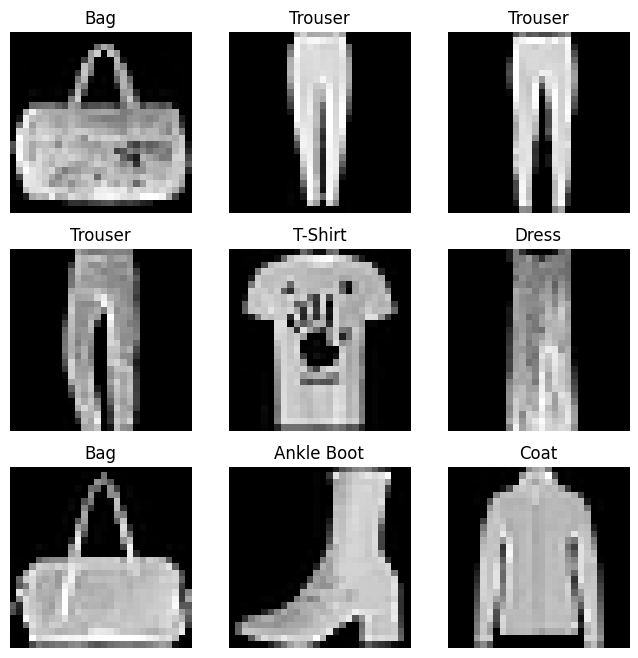

In [17]:
# Map class indices to their respective textual labels.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Create a new figure of size 8x8 inches.
figure = plt.figure(figsize=(8, 8))
# Define the number of columns and rows for the subplot layout.
cols, rows = 3, 3
# Iterate through the subplots of the figure.
for i in range(1, cols * rows + 1):
    # Generate a random index to extract a sample from the training dataset.
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # Extract the image and its corresponding label from the training dataset.
    img, label = training_data[sample_idx]
    # Add a new subplot to the figure.
    figure.add_subplot(rows, cols, i)
    # Set the title of the subplot with the corresponding label.
    plt.title(labels_map[label])
    # Disable axes for better visualization.
    plt.axis("off")
    # Display the image as grayscale.
    plt.imshow(img.squeeze(), cmap="gray")

# Show the complete figure with subplots.
plt.show()


# Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In the next sections, we’ll break down what’s happening in each of these functions:

In [18]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # Initialize the dataset by loading annotations file and setting attributes
        self.img_labels = pd.read_csv(annotations_file)  # Load image labels from a CSV file
        self.img_dir = img_dir  # Directory containing the images
        self.transform = transform  # Transformation to apply to the images
        self.target_transform = target_transform  # Transformation to apply to the labels

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Get a sample from the dataset by index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])  # Get the image path
        image = read_image(img_path)  # Read the image using torchvision.io.read_image()
        label = self.img_labels.iloc[idx, 1]  # Get the label for the image

        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label  # Return the transformed image and label for the sample


Specifically:
The ***__init__*** function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms.

In [19]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

The ***__len__*** function returns the number of samples in our dataset.

In [20]:
def __len__(self):
    return len(self.img_labels)

The ***__getitem__*** function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

In [21]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

# Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


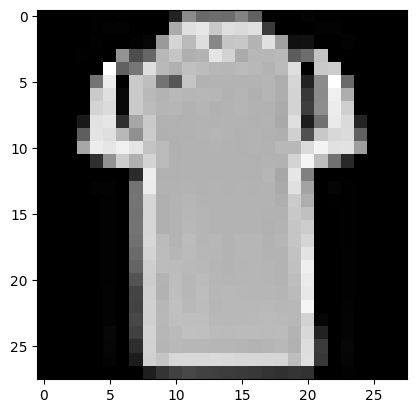

Label: 0


In [23]:
# Retrieving a batch of data from the training dataloader
train_features, train_labels = next(iter(train_dataloader))

# Printing the shape of the feature batch and label batch
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Displaying the first image and its corresponding label from the batch
img = train_features[0].squeeze()
label = train_labels[0]

# Showing the image using grayscale colormap
plt.imshow(img, cmap="gray")
plt.show()

# Printing the label associated with the image
print(f"Label: {label}")

Description:

* This code snippet is for loading and processing data using PyTorch's DataLoader class, which is part of the torch.utils.data module.
* It imports the DataLoader class from PyTorch.
* It creates two DataLoader objects, ***train_dataloader*** and ***test_dataloader***, for training and testing datasets respectively.
* Each DataLoader is initialized with a ***dataset*** (training_data and test_data), a batch size of ***64***, and shuffle set to True to shuffle the data before each epoch.
* It retrieves a batch of data from the train_dataloader using next(iter(train_dataloader)).
The features and labels of the batch are stored in train_features and train_labels respectively.
* It prints the shapes of the feature and label batches.
* It displays the ***first*** image from the batch using plt.imshow() with a grayscale colormap and its corresponding label.

# Reference
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# Author
Vetrano Alessio, 2024